## Cell 1: Import Libraries

This cell imports all necessary Python libraries for building and training the VAE. It includes PyTorch for deep learning, torchvision for CIFAR-10 dataset handling, matplotlib for plotting, and numpy for numerical operations.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

## Cell 2: Data Loading

This cell loads the CIFAR-10 dataset using torchvision. It applies normalization to transform pixel values from [0,255] to [-1,1] range, which is better for training neural networks. It creates training and test data loaders with batch size 128, and prepares a fixed batch for consistent monitoring during training.

In [6]:
# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Fixed batch for monitoring
fixed_batch = next(iter(test_loader))

## Cell 3: VAE Model Definition

This cell defines the Variational Autoencoder architecture. The encoder uses convolutional layers to compress 32x32 RGB images into a 64-dimensional latent space, outputting both mean (μ) and log-variance (log σ²) for the posterior distribution. The decoder uses transposed convolutions to reconstruct images from latent samples. The reparameterization trick allows backpropagation through the stochastic sampling process. The model automatically detects and uses MPS (Apple GPU), CUDA (NVIDIA GPU), or CPU based on availability, and prints which device type is selected.

In [ ]:
# VAE Model
class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # 8x8 -> 4x4
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), # 4x4 -> 2x2
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(256*2*2, latent_dim)
        self.fc_logvar = nn.Linear(256*2*2, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 256*2*2)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), # 2x2 -> 4x4
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), # 16x16 -> 32x32
            nn.Tanh()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, 256, 2, 2)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device.type.upper()}")
model = VAE().to(device)

Using device: MPS


## Cell 4: Loss Function

This cell defines the VAE loss function, which combines reconstruction loss and KL divergence regularization. The reconstruction loss uses Mean Squared Error (MSE) to measure how well the decoder reconstructs the input images. The KL divergence term regularizes the latent space by encouraging the learned posterior distributions to match the prior (standard normal distribution).

In [8]:
# Loss function
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (MSE)
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')

    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_loss, recon_loss, kl_loss

## Cell 5: Training Loop

This cell contains the complete training procedure. It uses Adam optimizer with learning rate 0.001, trains for up to 150 epochs with batch size 128. The training loop includes automatic checkpointing (every 10 epochs), reconstruction monitoring (every 20 epochs), and resume capability. Loss values are printed for each epoch, and the model can be safely interrupted and resumed later.

In [10]:
# Training setup
optimizer = optim.Adam(model.parameters(), lr=1e-3)
max_epochs = 150
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
recon_dir = './reconstructions'
os.makedirs(recon_dir, exist_ok=True)

# Resume from checkpoint if exists
start_epoch = 0
checkpoint_path = os.path.join(checkpoint_dir, 'vae_checkpoint.pth')
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Resuming from epoch {start_epoch}")

# Function to save reconstructions
def save_reconstructions(model, fixed_batch, epoch):
    model.eval()
    with torch.no_grad():
        fixed_images = fixed_batch[0].to(device)
        recon, _, _ = model(fixed_images)

        # Denormalize
        fixed_images = fixed_images * 0.5 + 0.5
        recon = recon * 0.5 + 0.5

        # Plot
        fig, axes = plt.subplots(2, 8, figsize=(16, 4))
        for i in range(8):
            axes[0, i].imshow(np.transpose(fixed_images[i].cpu().numpy(), (1, 2, 0)))
            axes[0, i].axis('off')
            axes[1, i].imshow(np.transpose(recon[i].cpu().numpy(), (1, 2, 0)))
            axes[1, i].axis('off')
        axes[0, 0].set_title('Original')
        axes[1, 0].set_title('Reconstructed')
        plt.savefig(os.path.join(recon_dir, f'recon_epoch_{epoch}.png'))
        plt.close()
    model.train()

# Training loop
for epoch in range(start_epoch, max_epochs):
    model.train()
    train_loss = 0
    train_recon_loss = 0
    train_kl_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss, recon_loss, kl_loss = loss_function(recon_batch, data, mu, logvar)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_kl_loss += kl_loss.item()

    # Average losses
    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon_loss = train_recon_loss / len(train_loader.dataset)
    avg_kl_loss = train_kl_loss / len(train_loader.dataset)

    print(f'Epoch {epoch+1}/{max_epochs}, Total Loss: {avg_loss:.4f}, Recon Loss: {avg_recon_loss:.4f}, KL Loss: {avg_kl_loss:.4f}')

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss
        }, os.path.join(checkpoint_dir, f'vae_checkpoint_epoch_{epoch+1}.pth'))
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss
        }, checkpoint_path)  # Latest checkpoint

    # Save reconstructions every 20 epochs
    if (epoch + 1) % 20 == 0:
        save_reconstructions(model, fixed_batch, epoch + 1)

print("Training completed!")

Resuming from epoch 80
Epoch 81/150, Total Loss: 181.5975, Recon Loss: 121.9881, KL Loss: 59.6094
Epoch 82/150, Total Loss: 181.6979, Recon Loss: 122.0658, KL Loss: 59.6321
Epoch 83/150, Total Loss: 181.7224, Recon Loss: 122.0754, KL Loss: 59.6470
Epoch 84/150, Total Loss: 181.5781, Recon Loss: 121.9652, KL Loss: 59.6128
Epoch 85/150, Total Loss: 181.5566, Recon Loss: 121.9799, KL Loss: 59.5767
Epoch 86/150, Total Loss: 181.6027, Recon Loss: 121.9566, KL Loss: 59.6461
Epoch 87/150, Total Loss: 181.6129, Recon Loss: 121.9892, KL Loss: 59.6237
Epoch 88/150, Total Loss: 181.4390, Recon Loss: 121.8095, KL Loss: 59.6295
Epoch 89/150, Total Loss: 181.4032, Recon Loss: 121.7769, KL Loss: 59.6263
Epoch 90/150, Total Loss: 181.4220, Recon Loss: 121.7996, KL Loss: 59.6224
Epoch 91/150, Total Loss: 181.4942, Recon Loss: 121.8273, KL Loss: 59.6669
Epoch 92/150, Total Loss: 181.3138, Recon Loss: 121.6143, KL Loss: 59.6994
Epoch 93/150, Total Loss: 181.3747, Recon Loss: 121.7140, KL Loss: 59.6606
Ep

In [9]:
model = VAE(latent_dim=64).to(device)

# Load checkpoint - find the latest available checkpoint
import glob

checkpoint_files = glob.glob('./checkpoints/vae_checkpoint_epoch_*.pth')
if checkpoint_files:
    # Find the latest checkpoint
    latest_checkpoint = max(checkpoint_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
    checkpoint = torch.load(latest_checkpoint, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Model loaded from {latest_checkpoint} (epoch {checkpoint['epoch']})")
else:
    print("❌ No checkpoint files found in ./checkpoints/ directory")
    print("Please run the training first or check if checkpoints exist")

# Switch to evaluation mode
model.eval()

model.eval()
test_loss, recon_loss, kl_loss = 0, 0, 0
with torch.no_grad():
    for x, _ in test_loader:  # use CIFAR-10 test set
        x = x.to(device)
        recon, mu, logvar = model(x)
        loss, recon_b, kl_b = loss_function(recon, x, mu, logvar)
        test_loss += loss.item()
        recon_loss += recon_b.item()
        kl_loss += kl_b.item()

n = len(test_loader.dataset)
print(f"Avg Test Loss: {test_loss/n:.4f}, Recon: {recon_loss/n:.4f}, KL: {kl_loss/n:.4f}")

✅ Model loaded from ./checkpoints/vae_checkpoint_epoch_150.pth (epoch 150)
Avg Test Loss: 185.1841, Recon: 125.3279, KL: 59.8562


## Cell 6: Load Trained Model and Evaluate

This cell loads the most recent trained VAE model from the checkpoints directory and evaluates its performance on the CIFAR-10 test set. It automatically finds and loads the latest checkpoint, switches the model to evaluation mode, and computes the average test loss including reconstruction and KL divergence components. This provides a quantitative measure of the model's performance on unseen data.

In [10]:
# Device information
print(f"Using device: {device}")
print(f"Device type: {device.type.upper()}")
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Quick test
model.eval()
with torch.no_grad():
    test_data = next(iter(train_loader))[0][:4].to(device)
    recon, mu, logvar = model(test_data)
    loss, recon_loss, kl_loss = loss_function(recon, test_data, mu, logvar)
    print(f"Test Loss: {loss.item():.4f}, Recon: {recon_loss.item():.4f}, KL: {kl_loss.item():.4f}")
    print(f"Output shape: {recon.shape}")
model.train()

Using device: mps
Device type: MPS
MPS available: True
CUDA available: False
Test Loss: 919.7404, Recon: 644.0677, KL: 275.6726
Output shape: torch.Size([4, 3, 32, 32])


VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=1024, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=1024, out_features=64, bias=True)
  (decoder_input): Linear(in_features=64, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(3

# In-Depth Analysis of the VAE

This section provides tools for analyzing the trained VAE model. We'll explore latent space visualization, sample generation, interpolation, and reconstruction quality assessment.

In [11]:
# Install additional packages for analysis
# This cell installs scikit-learn and seaborn for advanced analysis

try:
    import sklearn
    import seaborn
    print("Required packages already installed")
except ImportError:
    print("Installing required packages...")
    %pip install scikit-learn seaborn

Required packages already installed


In [12]:
# Load trained model for analysis
# This cell loads the latest checkpoint if training has been done previously

import glob

checkpoint_files = glob.glob('./checkpoints/vae_checkpoint_epoch_*.pth')
if checkpoint_files:
    # Find the latest checkpoint
    latest_checkpoint = max(checkpoint_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
    checkpoint = torch.load(latest_checkpoint, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded model from {latest_checkpoint} (epoch {checkpoint['epoch']})")
else:
    print("No checkpoints found. Using the current untrained model.")

model.eval()

Loaded model from ./checkpoints/vae_checkpoint_epoch_150.pth (epoch 150)


VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=1024, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=1024, out_features=64, bias=True)
  (decoder_input): Linear(in_features=64, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(3

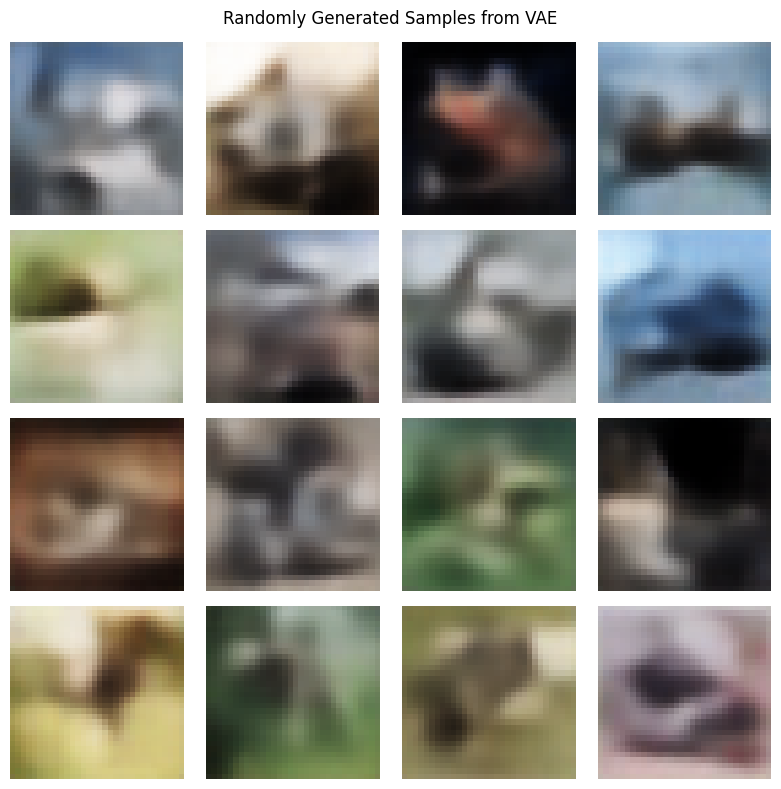

In [14]:
# Generate random samples from latent space
# This cell generates new images by sampling from the standard normal distribution in latent space

def generate_samples(model, num_samples=16, latent_dim=64):
    model.eval()
    with torch.no_grad():
        # Sample from standard normal
        z = torch.randn(num_samples, latent_dim).to(device)
        samples = model.decode(z)
        # Denormalize from [-1, 1] to [0, 1]
        samples = samples * 0.5 + 0.5
        return samples

# Generate and display samples
samples = generate_samples(model, num_samples=16)

# Plot the generated samples
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(16):
    ax = axes[i//4, i%4]
    ax.imshow(np.transpose(samples[i].cpu().numpy(), (1, 2, 0)))
    ax.axis('off')
plt.suptitle('Randomly Generated Samples from VAE')
plt.tight_layout()
plt.show()

## Cell 10: Latent Space Visualization

Use this cell to visualize encoded test images in 2D using either t-SNE (default) or PCA.
- To switch to PCA: change the function call at the bottom to method='pca'.
- The legend is fixed and placed to the right to avoid squeezing, with class names matching colors.

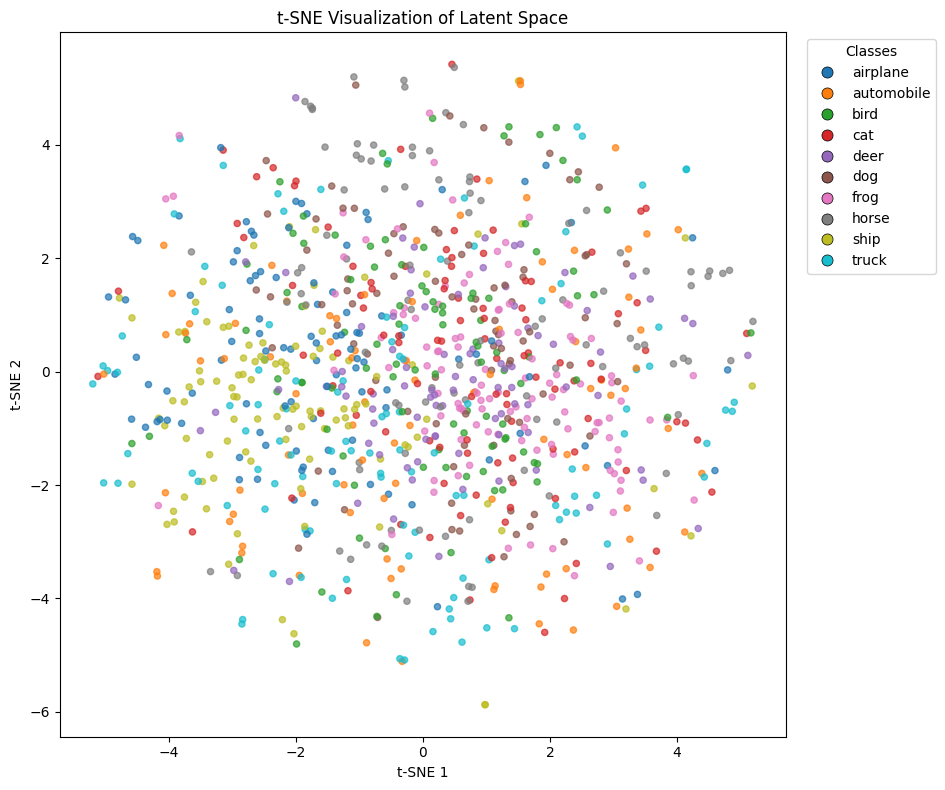

In [15]:
# Latent space visualization (t-SNE or PCA)
# This cell encodes a batch of test images and visualizes their latent representations using t-SNE or PCA

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns


def visualize_latent_space(model, data_loader, num_samples=1000, method='tsne'):
    """
    Visualize latent space with dimensionality reduction.
    method: 'tsne' or 'pca'
    """
    assert method in ('tsne', 'pca'), "method must be 'tsne' or 'pca'"

    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            mu, _ = model.encode(data)
            latents.append(mu.cpu().numpy())
            labels.append(target.numpy())

            if len(latents) * batch_size >= num_samples:
                break

    latents = np.concatenate(latents)[:num_samples]
    labels = np.concatenate(labels)[:num_samples]

    # Reduce to 2D
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
        pts2d = reducer.fit_transform(latents)
        title = 't-SNE Visualization of Latent Space'
        xlab, ylab = 't-SNE 1', 't-SNE 2'
    else:
        reducer = PCA(n_components=2, random_state=42)
        pts2d = reducer.fit_transform(latents)
        evr = getattr(reducer, 'explained_variance_ratio_', [0, 0])
        title = 'PCA Visualization of Latent Space'
        xlab = f'PC 1 (variance {evr[0]*100:.1f}%)'
        ylab = f'PC 2 (variance {evr[1]*100:.1f}%)'

    # Plot with a fixed, well-aligned legend
    fig, ax = plt.subplots(figsize=(12, 8))
    cmap = plt.get_cmap('tab10')

    ax.scatter(pts2d[:, 0], pts2d[:, 1], c=labels, cmap=cmap, alpha=0.7, s=20)

    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

    # Stable legend with all CIFAR-10 classes
    cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                       'dog', 'frog', 'horse', 'ship', 'truck']
    handles = [
        plt.Line2D(
            [0], [0], marker='o', color='w', label=cls_name,
            markerfacecolor=cmap(i), markeredgecolor='k', markeredgewidth=0.5, markersize=8
        )
        for i, cls_name in enumerate(cifar10_classes)
    ]
    ax.legend(handles=handles, title='Classes', loc='upper left', bbox_to_anchor=(1.02, 1), frameon=True)

    # Reserve room for legend
    plt.tight_layout(rect=[0, 0, 0.8, 1])
    plt.show()


# Visualize latent space for test data (set method to 'tsne' for t-SNE)
visualize_latent_space(model, test_loader, method='tsne')

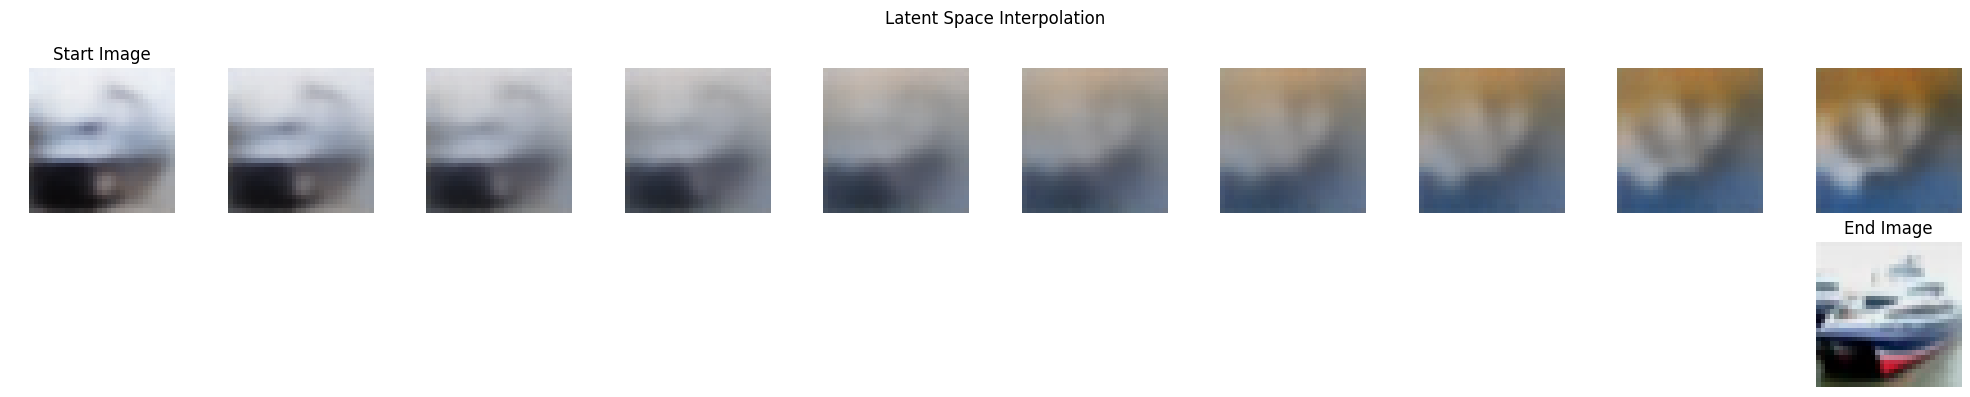

In [31]:
# Latent space interpolation
# This cell demonstrates smooth interpolation between two random points in latent space

def interpolate_latent_space(model, z1, z2, num_steps=10):
    """Interpolate between two latent vectors"""
    model.eval()
    with torch.no_grad():
        # Create interpolation path
        alphas = torch.linspace(0, 1, num_steps).to(device)
        z_interp = []
        for alpha in alphas:
            z = alpha * z1 + (1 - alpha) * z2
            z_interp.append(z.unsqueeze(0))

        z_interp = torch.cat(z_interp, dim=0)
        samples = model.decode(z_interp)
        samples = samples * 0.5 + 0.5  # Denormalize
        return samples

# Get two random latent vectors from test data
model.eval()
with torch.no_grad():
    test_batch = next(iter(test_loader))[0][:2].to(device)
    mu1, _ = model.encode(test_batch[0:1])
    mu2, _ = model.encode(test_batch[1:2])

# Interpolate between them
interpolated_samples = interpolate_latent_space(model, mu1.squeeze(), mu2.squeeze(), num_steps=10)

# Plot interpolation
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Original images
axes[0, 0].imshow(np.transpose((test_batch[0] * 0.5 + 0.5).cpu().numpy(), (1, 2, 0)))
axes[0, 0].set_title('Start Image')
axes[0, 0].axis('off')

axes[1, 9].imshow(np.transpose((test_batch[1] * 0.5 + 0.5).cpu().numpy(), (1, 2, 0)))
axes[1, 9].set_title('End Image')
axes[1, 9].axis('off')

# Interpolated images
for i in range(10):
    axes[0, i].imshow(np.transpose(interpolated_samples[i].cpu().numpy(), (1, 2, 0)))
    axes[0, i].axis('off')
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('Interpolation')
plt.suptitle('Latent Space Interpolation')
plt.tight_layout()
plt.show()

## Cell 11: Latent Space Interpolation

This cell demonstrates the continuity and smoothness of the learned latent space by interpolating between two different images. It takes two test images, encodes them to latent vectors, and creates a smooth transition by linearly interpolating between these vectors. The decoder then reconstructs images at each interpolation step, showing how the VAE creates realistic transitions between different images.

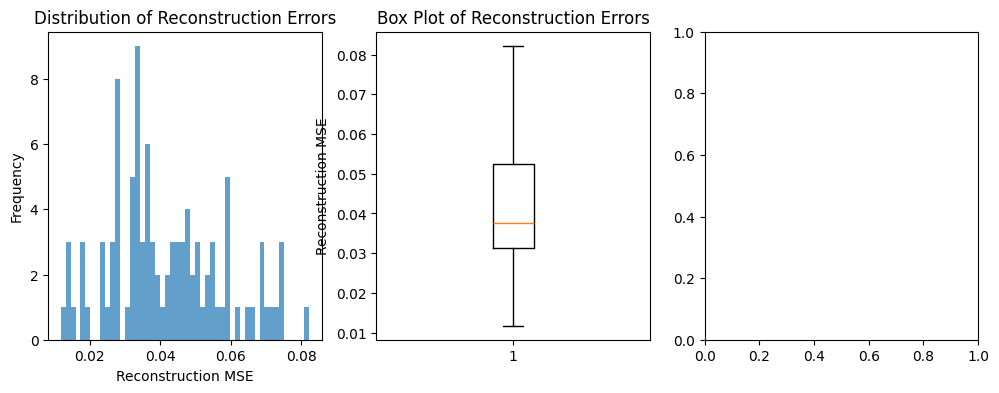

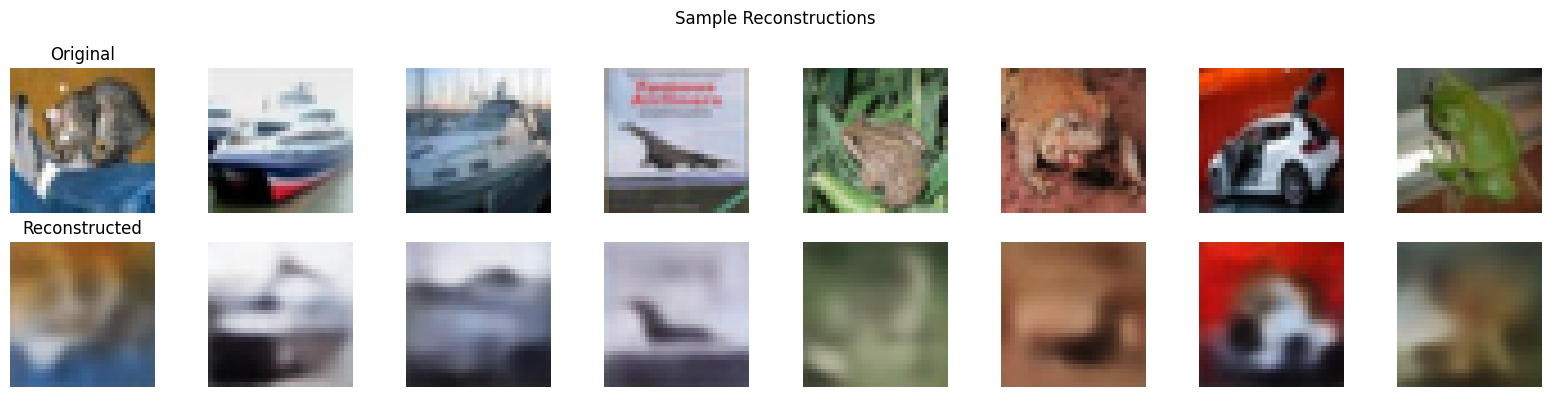

Mean reconstruction MSE: 0.041655
Median reconstruction MSE: 0.037489
Std reconstruction MSE: 0.016069


In [16]:
# Reconstruction quality analysis
# This cell evaluates reconstruction quality on test data and shows examples

def evaluate_reconstruction_quality(model, data_loader, num_samples=100):
    model.eval()
    recon_errors = []

    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            recon, _, _ = model(data)

            # Calculate MSE for each image
            mse = torch.mean((recon - data)**2, dim=[1,2,3])
            recon_errors.extend(mse.cpu().numpy())

            if len(recon_errors) >= num_samples:
                break

    recon_errors = np.array(recon_errors[:num_samples])

    # Plot distribution of reconstruction errors
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.hist(recon_errors, bins=50, alpha=0.7)
    plt.xlabel('Reconstruction MSE')
    plt.ylabel('Frequency')
    plt.title('Distribution of Reconstruction Errors')

    plt.subplot(1, 3, 2)
    plt.boxplot(recon_errors)
    plt.ylabel('Reconstruction MSE')
    plt.title('Box Plot of Reconstruction Errors')

    plt.subplot(1, 3, 3)
    # Show best and worst reconstructions
    test_batch = next(iter(data_loader))[0][:8].to(device)
    recon_batch, _, _ = model(test_batch)

    # Denormalize
    test_batch = test_batch * 0.5 + 0.5
    recon_batch = recon_batch * 0.5 + 0.5

    fig, axes = plt.subplots(2, 8, figsize=(16, 4))
    for i in range(8):
        axes[0, i].imshow(np.transpose(test_batch[i].cpu().numpy(), (1, 2, 0)))
        axes[0, i].axis('off')
        axes[1, i].imshow(np.transpose(recon_batch[i].detach().cpu().numpy(), (1, 2, 0)))
        axes[1, i].axis('off')
    axes[0, 0].set_title('Original')
    axes[1, 0].set_title('Reconstructed')
    plt.suptitle('Sample Reconstructions')
    plt.tight_layout()

    plt.show()

    print(f"Mean reconstruction MSE: {np.mean(recon_errors):.6f}")
    print(f"Median reconstruction MSE: {np.median(recon_errors):.6f}")
    print(f"Std reconstruction MSE: {np.std(recon_errors):.6f}")

evaluate_reconstruction_quality(model, test_loader)

## Cell 12: Reconstruction Quality Analysis

This cell quantitatively evaluates how well the VAE reconstructs images. It computes reconstruction errors (MSE) for 100 test images and shows their distribution through histograms and box plots. It also displays sample original vs reconstructed image pairs to visually assess reconstruction quality. The statistics help understand the average reconstruction performance and variability.

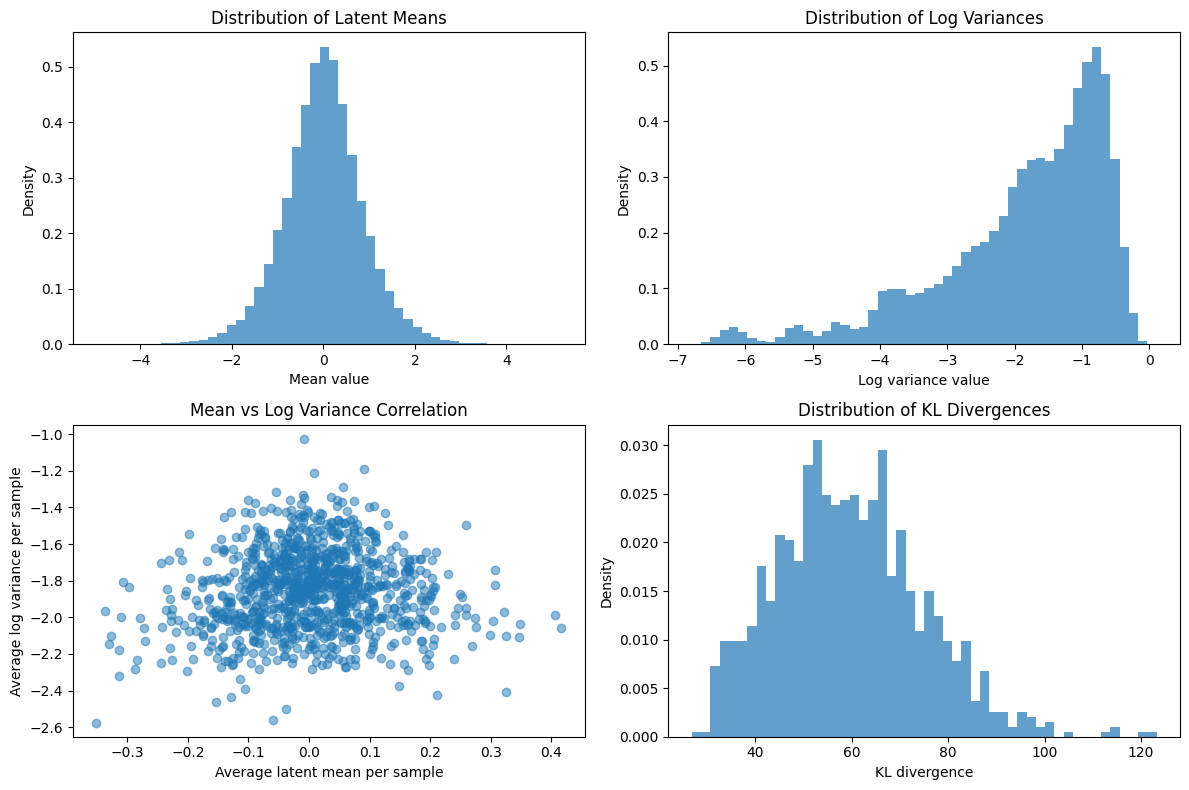

Latent dimension statistics:
Mean of means: 0.0027
Std of means: 0.8677
Mean of log variances: -1.8547
Std of log variances: 1.2343
Average KL divergence: 59.5928


In [29]:
# Latent space statistics analysis
# This cell analyzes the distribution of latent variables to check if they follow the expected normal distribution

def analyze_latent_statistics(model, data_loader, num_samples=1000):
    model.eval()
    all_mu = []
    all_logvar = []

    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            mu, logvar = model.encode(data)
            all_mu.append(mu.cpu().numpy())
            all_logvar.append(logvar.cpu().numpy())

            if len(all_mu) * batch_size >= num_samples:
                break

    all_mu = np.concatenate(all_mu)[:num_samples]
    all_logvar = np.concatenate(all_logvar)[:num_samples]

    # Plot statistics
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Mean distribution
    axes[0, 0].hist(all_mu.flatten(), bins=50, alpha=0.7, density=True)
    axes[0, 0].set_title('Distribution of Latent Means')
    axes[0, 0].set_xlabel('Mean value')
    axes[0, 0].set_ylabel('Density')

    # Log variance distribution
    axes[0, 1].hist(all_logvar.flatten(), bins=50, alpha=0.7, density=True)
    axes[0, 1].set_title('Distribution of Log Variances')
    axes[0, 1].set_xlabel('Log variance value')
    axes[0, 1].set_ylabel('Density')

    # Mean vs variance correlation
    axes[1, 0].scatter(all_mu.mean(axis=1), all_logvar.mean(axis=1), alpha=0.5)
    axes[1, 0].set_xlabel('Average latent mean per sample')
    axes[1, 0].set_ylabel('Average log variance per sample')
    axes[1, 0].set_title('Mean vs Log Variance Correlation')

    # KL divergence distribution
    kl_divs = -0.5 * np.sum(1 + all_logvar - all_mu**2 - np.exp(all_logvar), axis=1)
    axes[1, 1].hist(kl_divs, bins=50, alpha=0.7, density=True)
    axes[1, 1].set_title('Distribution of KL Divergences')
    axes[1, 1].set_xlabel('KL divergence')
    axes[1, 1].set_ylabel('Density')

    plt.tight_layout()
    plt.show()

    print(f"Latent dimension statistics:")
    print(f"Mean of means: {np.mean(all_mu):.4f}")
    print(f"Std of means: {np.std(all_mu):.4f}")
    print(f"Mean of log variances: {np.mean(all_logvar):.4f}")
    print(f"Std of log variances: {np.std(all_logvar):.4f}")
    print(f"Average KL divergence: {np.mean(kl_divs):.4f}")

analyze_latent_statistics(model, test_loader)

## Cell 13: Latent Space Statistics

This cell analyzes the statistical properties of the latent variables to verify if they follow the expected normal distribution. It examines the distributions of latent means and log-variances, their correlation, and the KL divergence values. This helps assess whether the VAE has learned appropriate posterior distributions and whether the regularization term (KL divergence) is working effectively.

Found 7 saved reconstruction files


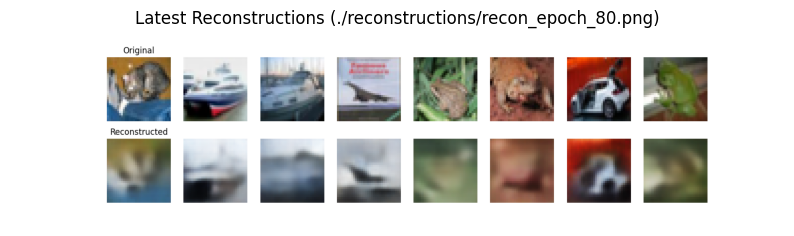

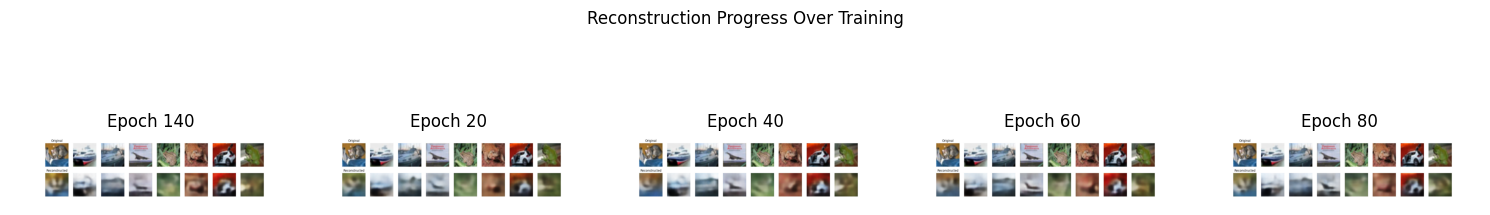

In [32]:
# Display saved reconstructions
# This cell loads and displays reconstruction images saved during training

import glob
from PIL import Image

recon_files = sorted(glob.glob('./reconstructions/recon_epoch_*.png'))
if recon_files:
    print(f"Found {len(recon_files)} saved reconstruction files")

    # Display the most recent reconstruction
    latest_recon = recon_files[-1]
    img = Image.open(latest_recon)
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.title(f'Latest Reconstructions ({latest_recon})')
    plt.axis('off')
    plt.show()

    # Show progression if multiple files exist
    if len(recon_files) > 1:
        fig, axes = plt.subplots(1, min(5, len(recon_files)), figsize=(15, 3))
        for i, recon_file in enumerate(recon_files[-5:]):
            img = Image.open(recon_file)
            axes[i].imshow(img)
            axes[i].set_title(f'Epoch {recon_file.split("_")[-1].split(".")[0]}')
            axes[i].axis('off')
        plt.suptitle('Reconstruction Progress Over Training')
        plt.tight_layout()
        plt.show()
else:
    print("No saved reconstruction files found. Run training first to generate them.")

## Cell 14: Display Saved Reconstructions

This cell loads and displays reconstruction images that were saved during training (every 20 epochs). It shows the most recent reconstruction comparison and, if multiple epochs have been saved, displays a progression over time. This allows you to visually track how reconstruction quality improves as training progresses.

## Cell 15: Generate PCA Visualizations for Checkpoints

This cell loads each checkpoint saved every 20 epochs, encodes a subset of test images, runs PCA to 2D, and saves a plot with a clean legend. Files are saved to `./latent_visualizations/latent_pca_epoch_{E}.png`.

In [34]:
# Generate PCA latent space visualizations for checkpoints
import glob, os
from sklearn.decomposition import PCA

latent_dir = './latent_visualizations'
os.makedirs(latent_dir, exist_ok=True)

def generate_pca_for_checkpoint(checkpoint_path, save_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    temp_model = VAE(latent_dim=64).to(device)
    temp_model.load_state_dict(checkpoint['model_state_dict'])
    temp_model.eval()
    epoch = checkpoint['epoch']

    # Collect latents
    latents, labels = [], []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            mu, _ = temp_model.encode(data)
            latents.append(mu.cpu().numpy())
            labels.append(target.numpy())
            if len(latents) * batch_size >= 1000:
                break

    latents = np.concatenate(latents)[:1000]
    labels = np.concatenate(labels)[:1000]

    # PCA
    pca = PCA(n_components=2, random_state=42)
    latents_2d = pca.fit_transform(latents)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 8))
    cmap = plt.get_cmap('tab10')
    ax.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap=cmap, alpha=0.7, s=20)
    cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                       'dog', 'frog', 'horse', 'ship', 'truck']
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label=cls_name,
                   markerfacecolor=cmap(i), markeredgecolor='k', markeredgewidth=0.5, markersize=8)
        for i, cls_name in enumerate(cifar10_classes)
    ]
    ax.legend(handles=handles, title='Classes', loc='upper left', bbox_to_anchor=(1.02, 1), frameon=True)
    ax.set_title(f'Latent Space (PCA) - Epoch {epoch}\nPC1 {pca.explained_variance_ratio_[0]*100:.1f}% | PC2 {pca.explained_variance_ratio_[1]*100:.1f}%')
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    plt.tight_layout(rect=[0, 0, 0.8, 1])
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close(fig)
    print(f'Saved PCA latent visualization for epoch {epoch} to {save_path}')

# Run over checkpoints
ckpts = sorted(glob.glob('./checkpoints/vae_checkpoint_epoch_*.pth'))
epoch_20_ckpts = [f for f in ckpts if (int(f.split('_')[-1].split('.')[0]) % 20 == 0)]
if epoch_20_ckpts:
    for ck in epoch_20_ckpts:
        ep = int(ck.split('_')[-1].split('.')[0])
        out = os.path.join(latent_dir, f'latent_pca_epoch_{ep}.png')
        if not os.path.exists(out):
            generate_pca_for_checkpoint(ck, out)
        else:
            print(f'PCA plot already exists for epoch {ep}, skipping.')
else:
    print('No checkpoints found at multiples of 20. Run training to generate them.')

Saved PCA latent visualization for epoch 100 to ./latent_visualizations/latent_pca_epoch_100.png
Saved PCA latent visualization for epoch 120 to ./latent_visualizations/latent_pca_epoch_120.png
Saved PCA latent visualization for epoch 140 to ./latent_visualizations/latent_pca_epoch_140.png
Saved PCA latent visualization for epoch 20 to ./latent_visualizations/latent_pca_epoch_20.png
Saved PCA latent visualization for epoch 40 to ./latent_visualizations/latent_pca_epoch_40.png
Saved PCA latent visualization for epoch 60 to ./latent_visualizations/latent_pca_epoch_60.png
Saved PCA latent visualization for epoch 80 to ./latent_visualizations/latent_pca_epoch_80.png


## Cell 16: Display PCA Latent Space Evolution

This cell loads the saved PCA plots and displays them in a grid so you can see how the latent space evolves every 20 epochs.

Found 7 PCA latent visualization files


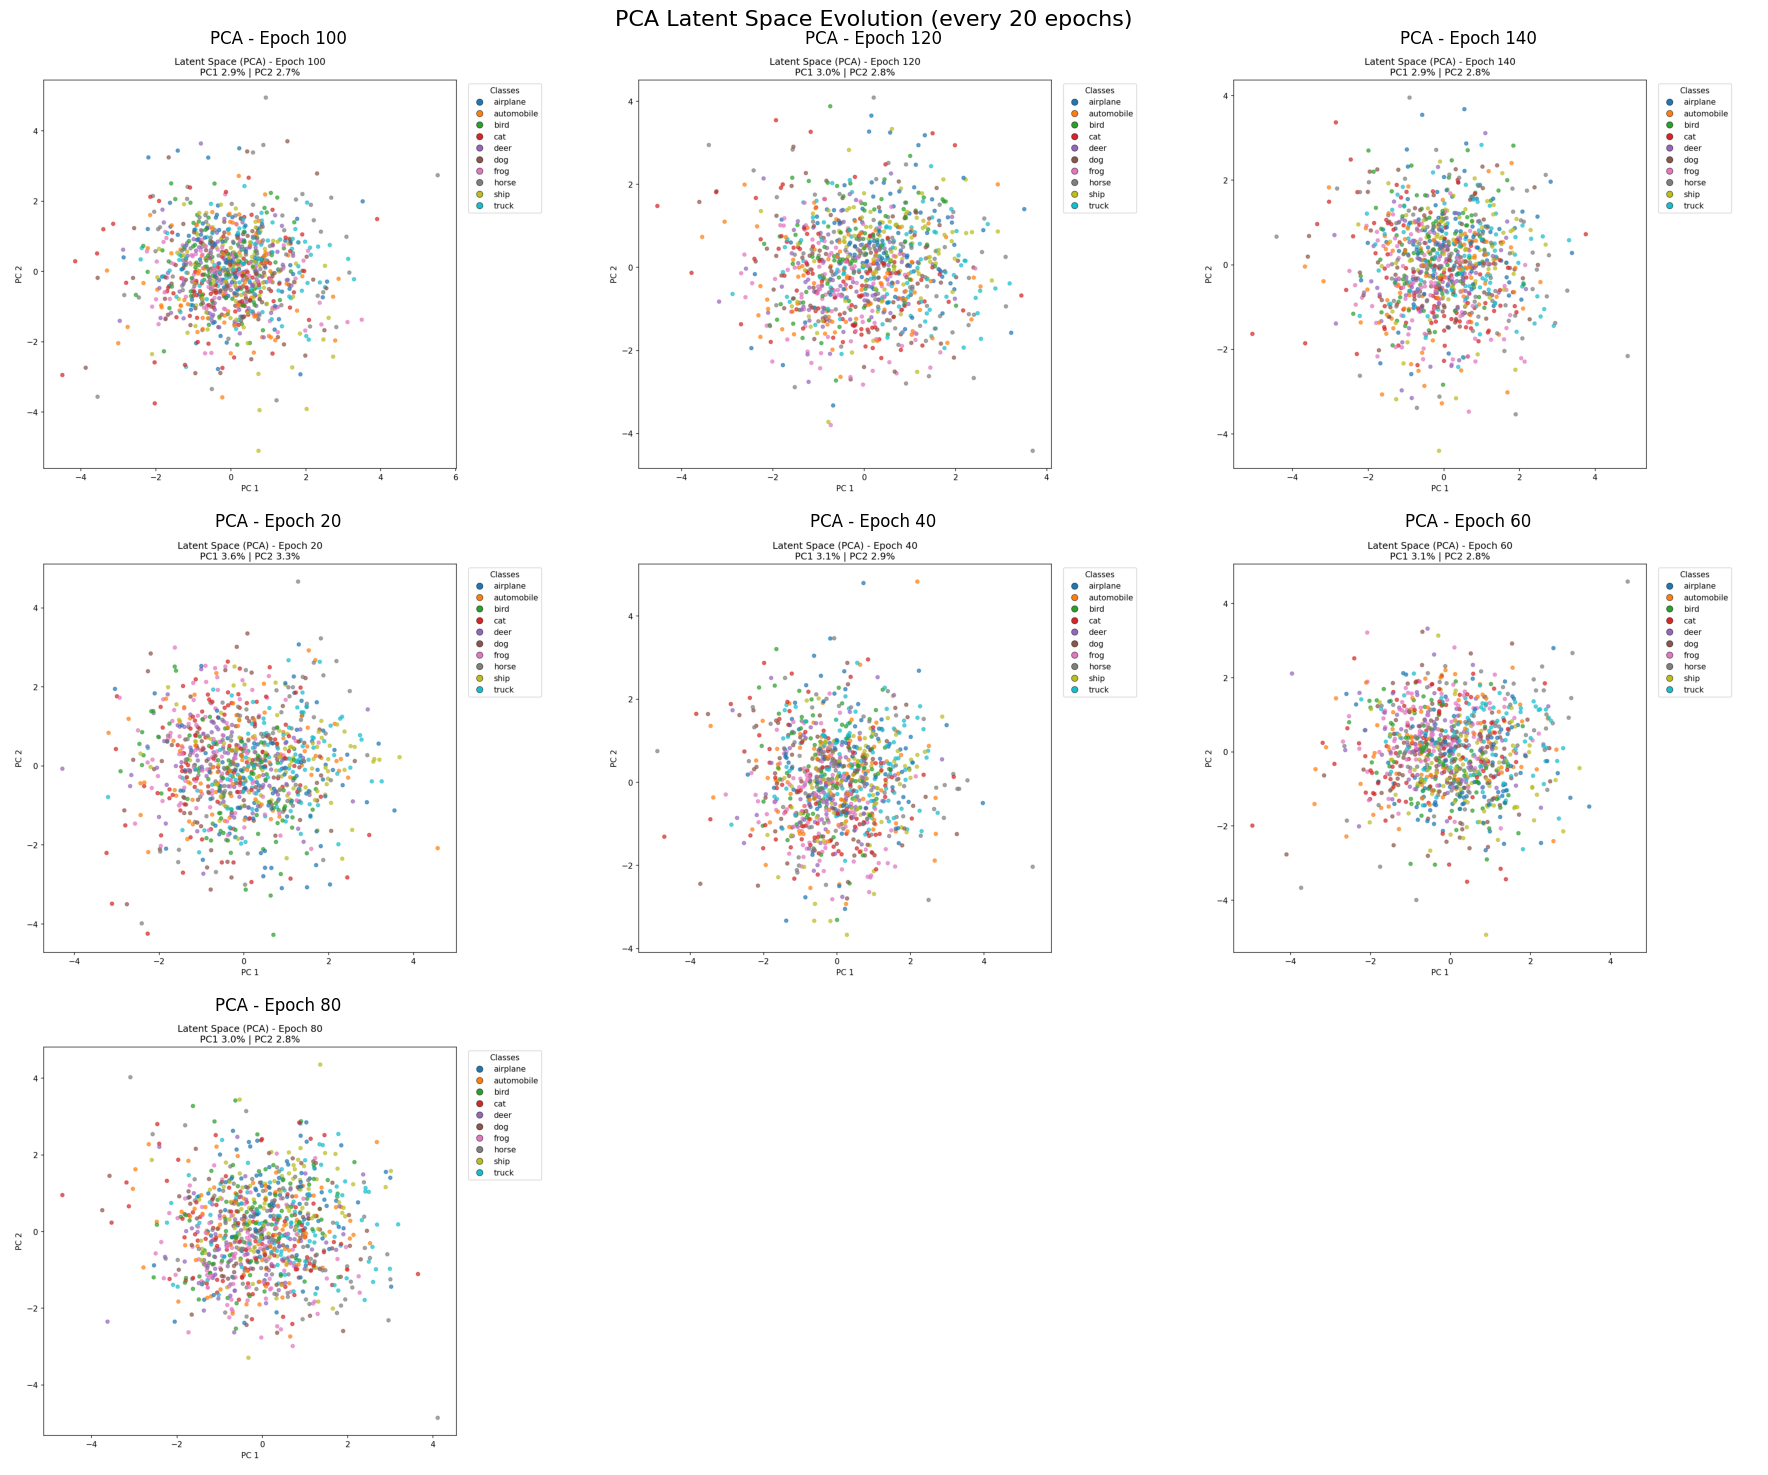

In [35]:
# Display PCA latent space evolution
import glob
from PIL import Image

pca_files = sorted(glob.glob('./latent_visualizations/latent_pca_epoch_*.png'))
if pca_files:
    print(f'Found {len(pca_files)} PCA latent visualization files')
    n_cols = min(3, len(pca_files))
    n_rows = (len(pca_files) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    for i, f in enumerate(pca_files):
        r, c = i // n_cols, i % n_cols
        img = Image.open(f)
        axes[r, c].imshow(img)
        ep = f.split('_')[-1].split('.')[0]
        axes[r, c].set_title(f'PCA - Epoch {ep}')
        axes[r, c].axis('off')
    for i in range(len(pca_files), n_rows*n_cols):
        r, c = i // n_cols, i % n_cols
        axes[r, c].axis('off')
    plt.suptitle('PCA Latent Space Evolution (every 20 epochs)', fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print('No PCA latent visualization files found. Run the checkpoint PCA generator cell first.')